In [1]:
# @title import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/laxmimerit/twitter-suicidal-intention-dataset.git

fatal: destination path 'twitter-suicidal-intention-dataset' already exists and is not an empty directory.


In [3]:
# @title import library
import os
import numpy as np
import pandas as pd
import seaborn as sn
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
!pip install torchmetrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [4]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [5]:
wv.mapfile_path

In [6]:
# Download the necessary nltk data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# @title Load dataset
data = pd.read_csv("/content/twitter-suicidal-intention-dataset/twitter-suicidal_data.csv")
data = data.to_numpy()

In [8]:
data

array([['my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives',
        1],
       ['muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels ',
        1],
       ['work slave i really feel like my only purpose in life is to make a higher man money parents forcing me through college and i have too much on my plate i owe a lot of money i know this is the easy way out but i am really tired all of these issues are on top of dealing with tensions in america as well i want to rest',
        1],
      

In [9]:
# Count the number of data in each main class
unique, counts = np.unique(data[:,1], return_counts=True)
unique, counts

(array([0, 1], dtype=object), array([5121, 3998]))

In [10]:
#@title Preprocessing
def remove_special_characters(string):
    return re.sub(r"[^a-zA-Z0-9]", " ", string)
def sentence_prep(sentence):
    # Tokenize the sentence into individual words
    tokens = word_tokenize(remove_special_characters(sentence))
    # Initialize the WordNetLemmatizer object for lemmatization
    wln = WordNetLemmatizer()
    # Normalize tokenized words by stemming or lemmatization
    normalized_tokens = []
    # ordered_tokens = set()
    stop_words = set(stopwords.words('english'))
    for token in tokens:
        normalized_token = wln.lemmatize(token.lower())
        # removal of duplicate words
        # if normalized_token not in ordered_tokens :
        if normalized_token not in stop_words:
            # ordered_tokens.add(normalized_token)
            normalized_tokens.append(normalized_token)

    return normalized_tokens

In [11]:
for row in data:
  row[0]=sentence_prep(row[0])

In [12]:
data[0]

array([list(['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'dont', 'want', 'create', 'meaning', 'creating', 'meaning', 'pain', 'long', 'hold', 'back', 'urge', 'run', 'car', 'head', 'first', 'next', 'person', 'coming', 'opposite', 'way', 'stop', 'feeling', 'jealous', 'tragic', 'character', 'like', 'gomer', 'pile', 'swift', 'end', 'able', 'bring', 'life']),
       1], dtype=object)

In [13]:
new_data =[]
for idx, sen in enumerate(data[:,0]) :
   if len(sen)  == 0 :
     continue
   new_data.append(data[idx])


In [14]:
data.shape

(9119, 2)

In [15]:
new_data = np.array(new_data)

In [16]:
data = new_data

In [17]:
# @title find_unknown_words
# Get the vocabulary from the Word2Vec model
vocab = set(wv.index_to_key)

def find_unknown_words(words):
    global total_words
    total_words += len(words)
    unknown_words = [word for word in words if word not in vocab]
    for unknown_word in unknown_words:
        words.remove(unknown_word)
    return words, len(unknown_words)

# Example usage on test data
unknown_words_count = 0
total_words = 0
for row in data:
    #print(row[0])
    row[0], count = find_unknown_words(row[0])
    unknown_words_count += count

print(f'{unknown_words_count / total_words * 100:.2f}% of words are unknown')


5.76% of words are unknown


In [18]:
#@title train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(data[:,1].reshape(-1, 1))
labels= enc.transform(data[:,1].reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(data[:,0], labels, test_size=0.2, stratify=labels)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7267,)
(7267, 2)
(1817,)
(1817, 2)


In [19]:
# Count the number of train_data in each main class
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

# Count the number of test_data in each main class
unique, counts = np.unique(y_test, return_counts=True)
print(unique, counts)

[0. 1.] [7267 7267]
[0. 1.] [1817 1817]


In [20]:
vec_king = wv['king']
# print(vec_king)
print("-"*20)
# Find words similar to a given word
similar_words = wv.most_similar('king', topn=5)
print("Words similar to 'king':", similar_words)

--------------------
Words similar to 'king': [('kings', 0.7138045430183411), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474)]


In [21]:
# Find how many words are in the longest sentence
longest = 0
for i in range(data.shape[0]):
    length = len(data[i,0])
    if length > longest:
        longest = length
print(longest)

2043


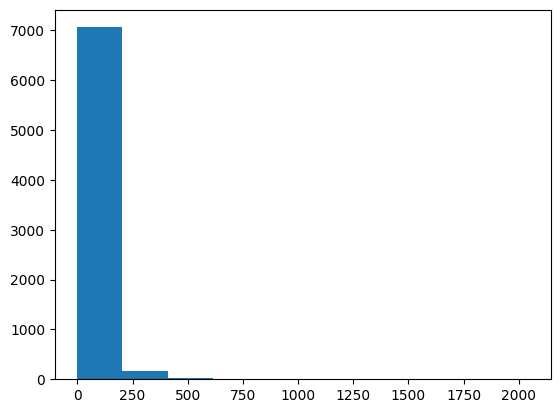

for train data; median =  12.0 min =  0.0 max =  2043.0


In [22]:
# Create a histogram of the length of the training sentences
lengths = np.zeros(X_train.shape[0])
for i in range(X_train.shape[0]):
    lengths[i] = len(X_train[i])

plt.hist(lengths)
plt.show()
median = np.median(lengths)
print('for train data; median = ', median,'min = ',np.min(lengths),'max = ',np.max(lengths))

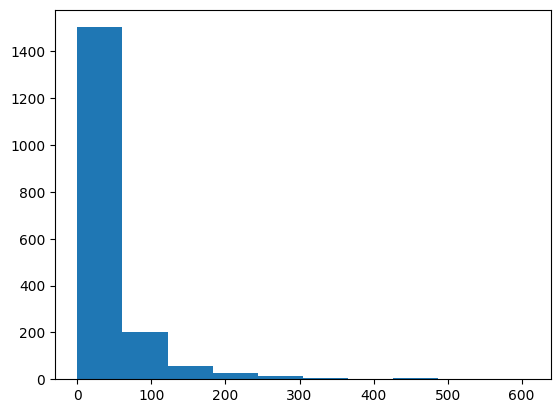

for test data; median =  12.0 min =  0.0 max =  609.0


In [23]:
# Create a histogram of the length of the training sentences
lengths = np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    lengths[i] = len(X_test[i])

plt.hist(lengths)
plt.show()
median = np.median(lengths)
print('for test data; median = ', median,'min = ',np.min(lengths),'max = ',np.max(lengths))

In [24]:
# @title class Word2VecDataset
from torch.utils.data import DataLoader, Dataset
import torch

size_of_all = 30

class Word2VecDataset(Dataset):
    def __init__(self, sentences, word2vec_model,y):
        self.sentences = sentences
        self.y = y
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # Convert words to embeddings
        embeddings = [self.word2vec_model[word] for word in self.sentences[idx]]
        size_of_all = 30
        X_data = np.zeros((int(size_of_all),300))
        if  np.shape(embeddings)[0] == 0:
          embeddings = np.zeros((1,300))

        X_data[-len(embeddings):,:] = embeddings[-int(size_of_all):]
        y1=self.y[idx]

        return torch.tensor(X_data),y1

In [25]:
train_dataset = Word2VecDataset(X_train, wv,y_train)
test_dataset = Word2VecDataset(X_test,wv, y_test)
for i in range(5):
  example = train_dataset[i]
  print(example[0].shape)

torch.Size([30, 300])
torch.Size([30, 300])
torch.Size([30, 300])
torch.Size([30, 300])
torch.Size([30, 300])


In [26]:
# @title DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [27]:
batch = next(iter(test_dataloader))
# print(batch)
for k,v in test_dataloader:
  #print(k,v)
  pass

In [28]:
torch.cuda.empty_cache()

In [29]:
# @title LSTMNetwork
import torch.nn as nn
from statistics import mean

class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size
                            , self.num_layers, batch_first=True)

        self.classifier = nn.Sequential( nn.Linear(100, 128)
                                       ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 2))

        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        x1, (hidden, _)= self.lstm(x)
        x2 = self.classifier(x1[:,-1,:])
        x3 = self.softmax(x2)
        return x3

In [30]:
import torch.optim as optim

hidden_size = 100
input_size = 300
num_layers = 1
lr = 0.001
batch_size = 2
torch.manual_seed(40)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model, the optimizer and criterion
model_1 = LSTMNetwork(input_size, hidden_size, num_layers)
model_1 = model_1.to(device)
optimizer = optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.BCELoss()

In [31]:
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from torch import tensor
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import F1Score
from torchmetrics import Recall
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1 = F1Score(task="multiclass",num_classes=2).to(device)
metric = BinaryAccuracy().to(device)
recall = Recall(task="multiclass", num_classes=2).to(device)

num_epochs = 40


for epoch in range(num_epochs):
    epoch_losses_train =[]
    epoch_losses_test =[]
    epoch_accuracy_train=[]
    epoch_accuracy_test=[]
    epoch_f1_train =[]
    epoch_f1_test =[]
    epoch_recall_train =[]
    epoch_recall_test =[]
    epoch_precision_train =[]
    epoch_precision_test =[]

    model_1.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        # print(batch[0].shape)

        outputs = model_1(batch[0].to(torch.float32).to(device))
        # print(outputs)
        loss = criterion(outputs, batch[1].to(torch.float32).to(device))
        accuracy_train=metric(outputs, batch[1].to(device))
        f1_train=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        recall_train=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        precision_train=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')

        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())
        epoch_accuracy_train.append(accuracy_train.item())
        epoch_f1_train.append(f1_train.item())
        epoch_recall_train.append(recall_train.item())
        epoch_precision_train.append(precision_train.item())

    for batch_test in tqdm(test_dataloader):
      model_1.eval()
      # forward pass
      with torch.no_grad():
        outputs = model_1(batch_test[0].to(torch.float32).to(device))
      loss_test = criterion(outputs, batch_test[1].to(torch.float32).to(device))
      accuracy_test=metric(outputs , batch_test[1].to(device))
      f1_test=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      recall_test=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      precision_test=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')

      epoch_losses_test.append(loss_test.item())
      epoch_accuracy_test.append(accuracy_test.item())
      epoch_f1_test.append(f1_test.item())
      epoch_recall_test.append(recall_test.item())
      epoch_precision_test.append(precision_test.item())

    print()
    print("#"*20)
    print(f'EPOCH: {epoch}')

    print("train")
    print(f'Mean loss: {mean(epoch_losses_train)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_train)}')
    print(f'Mean f1 : {mean(epoch_f1_train)}')
    print(f'Mean recall : {mean(epoch_recall_train)}')
    print(f'Mean recall : {mean(epoch_precision_train)}')

    print("test")
    print(f'Mean loss: {mean(epoch_losses_test)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_test)}')
    print(f'Mean f1 : {mean(epoch_f1_test)}')
    print(f'Mean recall : {mean(epoch_recall_test)}')
    print(f'Mean recall : {mean(epoch_precision_test)}')


  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/114 [00:00<01:26,  1.30it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/s


####################
EPOCH: 0
train
Mean loss: 0.39766696657527956
Mean accuracy: 0.8196311091121874
Mean f1 : 0.7864948764784901
Mean recall : 0.7854204001420094
Mean recall : 0.8083698543074356
test
Mean loss: 0.2608041958562259
Mean accuracy: 0.8887068958118044
Mean f1 : 0.8842835791190645
Mean recall : 0.8929505903753631
Mean recall : 0.8822514823796987


100%|██████████| 29/29 [00:00<00:00, 39.00it/s]



####################
EPOCH: 1
train
Mean loss: 0.24610717241701327
Mean accuracy: 0.8961779449069709
Mean f1 : 0.8922521545339309
Mean recall : 0.8989630934485242
Mean recall : 0.8914144993562055
test
Mean loss: 0.2221500537004964
Mean accuracy: 0.9048706889152527
Mean f1 : 0.900520395128772
Mean recall : 0.908337980322337
Mean recall : 0.8984263831411127


100%|██████████| 29/29 [00:00<00:00, 53.53it/s]



####################
EPOCH: 2
train
Mean loss: 0.2139156285608024
Mean accuracy: 0.9091752819847643
Mean f1 : 0.9054892426964579
Mean recall : 0.9107820600258061
Mean recall : 0.9044562392999159
test
Mean loss: 0.21155723055888867
Mean accuracy: 0.9070258613290458
Mean f1 : 0.9026872598262279
Mean recall : 0.9077804351755453
Mean recall : 0.9019091789059062


100%|██████████| 29/29 [00:00<00:00, 55.61it/s]



####################
EPOCH: 3
train
Mean loss: 0.19201376210702092
Mean accuracy: 0.9187695802303782
Mean f1 : 0.9161239364807369
Mean recall : 0.9205955639816217
Mean recall : 0.9150664195929255
test
Mean loss: 0.23380883487647977
Mean accuracy: 0.905409482018701
Mean f1 : 0.9002785938750286
Mean recall : 0.9103961268515227
Mean recall : 0.8984514372171768


100%|██████████| 29/29 [00:00<00:00, 54.04it/s]



####################
EPOCH: 4
train
Mean loss: 0.16766512037761377
Mean accuracy: 0.9264450188268695
Mean f1 : 0.9241108423911816
Mean recall : 0.9263701738318942
Mean recall : 0.9251963072416425
test
Mean loss: 0.2340565647544532
Mean accuracy: 0.9080387929390217
Mean f1 : 0.9048720010750106
Mean recall : 0.9112084680590249
Mean recall : 0.9037260759450337


100%|██████████| 29/29 [00:00<00:00, 37.38it/s]



####################
EPOCH: 5
train
Mean loss: 0.15821265742967003
Mean accuracy: 0.9335722118093256
Mean f1 : 0.9318142259412289
Mean recall : 0.9336845966937906
Mean recall : 0.9334976080005905
test
Mean loss: 0.21752280767621665
Mean accuracy: 0.9134267239735044
Mean f1 : 0.9112365408818327
Mean recall : 0.9163585542002067
Mean recall : 0.9112167777576512


100%|██████████| 29/29 [00:00<00:00, 54.46it/s]



####################
EPOCH: 6
train
Mean loss: 0.12563908884399816
Mean accuracy: 0.9470942982456141
Mean f1 : 0.9455323093079512
Mean recall : 0.9477589421982184
Mean recall : 0.946435810887988
test
Mean loss: 0.23906826304978337
Mean accuracy: 0.9040301729892862
Mean f1 : 0.9019360678747229
Mean recall : 0.9013969361225167
Mean recall : 0.906670096304216


100%|██████████| 29/29 [00:00<00:00, 54.19it/s]



####################
EPOCH: 7
train
Mean loss: 0.12188876864680073
Mean accuracy: 0.9528743734485224
Mean f1 : 0.9513482982346934
Mean recall : 0.9529602339333405
Mean recall : 0.9522435158255371
test
Mean loss: 0.2526735344837452
Mean accuracy: 0.9074999998355734
Mean f1 : 0.9038307959145093
Mean recall : 0.9085705132243962
Mean recall : 0.9028787382181256


100%|██████████| 29/29 [00:00<00:00, 55.01it/s]



####################
EPOCH: 8
train
Mean loss: 0.10477831588829295
Mean accuracy: 0.9584703947368421
Mean f1 : 0.9571827561398141
Mean recall : 0.9579225001551525
Mean recall : 0.9580221779424719
test
Mean loss: 0.2550374649722001
Mean accuracy: 0.9097198268462872
Mean f1 : 0.9059650943037868
Mean recall : 0.9081456018875114
Mean recall : 0.9065491861757474


100%|██████████| 29/29 [00:00<00:00, 56.58it/s]



####################
EPOCH: 9
train
Mean loss: 0.0835973541252315
Mean accuracy: 0.970007048887119
Mean f1 : 0.969044329596151
Mean recall : 0.9694189095169672
Mean recall : 0.9698763378915572
test
Mean loss: 0.2510703938274548
Mean accuracy: 0.9110344833341139
Mean f1 : 0.9090496997987058
Mean recall : 0.910910690578824
Mean recall : 0.910295996095446


100%|██████████| 29/29 [00:00<00:00, 39.62it/s]



####################
EPOCH: 10
train
Mean loss: 0.07011750677044977
Mean accuracy: 0.9737312030373958
Mean f1 : 0.9728603386286977
Mean recall : 0.97354800288774
Mean recall : 0.9730090607993963
test
Mean loss: 0.2929309902006182
Mean accuracy: 0.9067241385065276
Mean f1 : 0.902964733263903
Mean recall : 0.9088650620991555
Mean recall : 0.9012768821354101


100%|██████████| 29/29 [00:00<00:00, 55.26it/s]



####################
EPOCH: 11
train
Mean loss: 0.07045081017228465
Mean accuracy: 0.9726347118093256
Mean f1 : 0.971836261365494
Mean recall : 0.9724008083448199
Mean recall : 0.9723971674565636
test
Mean loss: 0.2977969045269078
Mean accuracy: 0.9070258613290458
Mean f1 : 0.9042315105157922
Mean recall : 0.9049126094379377
Mean recall : 0.9049883230209746


100%|██████████| 29/29 [00:00<00:00, 55.34it/s]



####################
EPOCH: 12
train
Mean loss: 0.05021154785757525
Mean accuracy: 0.9810855263157895
Mean f1 : 0.9805349515682505
Mean recall : 0.9804945725949137
Mean recall : 0.9813152693423488
test
Mean loss: 0.3590564427190813
Mean accuracy: 0.912176724137931
Mean f1 : 0.9095030578421063
Mean recall : 0.9103929680799506
Mean recall : 0.9108593769391385


100%|██████████| 29/29 [00:00<00:00, 57.16it/s]



####################
EPOCH: 13
train
Mean loss: 0.04005409495316838
Mean accuracy: 0.9849232456140351
Mean f1 : 0.9844994668187687
Mean recall : 0.984564482974822
Mean recall : 0.9851178102214933
test
Mean loss: 0.4638517283160111
Mean accuracy: 0.904202586617963
Mean f1 : 0.901508337127496
Mean recall : 0.9033107242203497
Mean recall : 0.9034978655611932


100%|██████████| 29/29 [00:00<00:00, 38.28it/s]



####################
EPOCH: 14
train
Mean loss: 0.04207810377926778
Mean accuracy: 0.9834155701754386
Mean f1 : 0.9829060266522269
Mean recall : 0.9825547639925353
Mean recall : 0.9840449133630643
test
Mean loss: 0.48729317262768745
Mean accuracy: 0.9081034475359423
Mean f1 : 0.9038181069538774
Mean recall : 0.9102316983548154
Mean recall : 0.9016909494272891


100%|██████████| 29/29 [00:00<00:00, 43.56it/s]



####################
EPOCH: 15
train
Mean loss: 0.02563016772527542
Mean accuracy: 0.9897203947368421
Mean f1 : 0.9894413267258378
Mean recall : 0.9890860080005843
Mean recall : 0.9902308334562633
test
Mean loss: 0.6021286290267418
Mean accuracy: 0.904202586617963
Mean f1 : 0.9013178368423743
Mean recall : 0.9020749809688455
Mean recall : 0.9038579259887513


100%|██████████| 29/29 [00:00<00:00, 56.03it/s]



####################
EPOCH: 16
train
Mean loss: 0.022164731421007514
Mean accuracy: 0.990953947368421
Mean f1 : 0.9907030467341003
Mean recall : 0.9906392783153652
Mean recall : 0.9911269035648427
test
Mean loss: 0.7914009844434673
Mean accuracy: 0.9047413797214113
Mean f1 : 0.9021378364117809
Mean recall : 0.9045220428698335
Mean recall : 0.9042428667730026


100%|██████████| 29/29 [00:00<00:00, 56.06it/s]



####################
EPOCH: 17
train
Mean loss: 0.018046944059167066
Mean accuracy: 0.9919368734485224
Mean f1 : 0.9917519865884075
Mean recall : 0.9918198117073254
Mean recall : 0.9919508085424671
test
Mean loss: 0.8514853078743507
Mean accuracy: 0.9069612067321251
Mean f1 : 0.9034350482364978
Mean recall : 0.9053500207046182
Mean recall : 0.9043298443601828


100%|██████████| 29/29 [00:00<00:00, 56.60it/s]



####################
EPOCH: 18
train
Mean loss: 0.27618702651887905
Mean accuracy: 0.9144854323382963
Mean f1 : 0.9027823281315878
Mean recall : 0.9139766647008833
Mean recall : 0.9103099317211422
test
Mean loss: 0.8226231274933651
Mean accuracy: 0.4238793099748677
Mean f1 : 0.35023078021680976
Mean recall : 0.3424566400887877
Mean recall : 0.38901452716122076


100%|██████████| 29/29 [00:00<00:00, 37.61it/s]



####################
EPOCH: 19
train
Mean loss: 0.5055306464956518
Mean accuracy: 0.7422619048963514
Mean f1 : 0.7146793952212225
Mean recall : 0.7242335580733658
Mean recall : 0.7280316025093138
test
Mean loss: 0.40899007895897177
Mean accuracy: 0.835775862480032
Mean f1 : 0.830151670836842
Mean recall : 0.832960534466023
Mean recall : 0.832195872934248


100%|██████████| 29/29 [00:00<00:00, 54.45it/s]



####################
EPOCH: 20
train
Mean loss: 0.33900098620276703
Mean accuracy: 0.8463150064150492
Mean f1 : 0.841310104052058
Mean recall : 0.8458865895714409
Mean recall : 0.8444355175608914
test
Mean loss: 0.3698750174251096
Mean accuracy: 0.837693964612895
Mean f1 : 0.8333255834228276
Mean recall : 0.8338472430289724
Mean recall : 0.8399110663932998


100%|██████████| 29/29 [00:00<00:00, 56.41it/s]



####################
EPOCH: 21
train
Mean loss: 0.2830249528613007
Mean accuracy: 0.8808270677139884
Mean f1 : 0.8771723313825959
Mean recall : 0.8806745168906965
Mean recall : 0.8792063395229603
test
Mean loss: 0.3397373366972496
Mean accuracy: 0.8611637929390217
Mean f1 : 0.8567301403926073
Mean recall : 0.8600430981391775
Mean recall : 0.8580557165574357


100%|██████████| 29/29 [00:00<00:00, 56.40it/s]



####################
EPOCH: 22
train
Mean loss: 0.23861565388608397
Mean accuracy: 0.9031445802303782
Mean f1 : 0.9001757650507801
Mean recall : 0.9033217602925498
Mean recall : 0.9009233783558966
test
Mean loss: 0.31126072283448847
Mean accuracy: 0.868943964612895
Mean f1 : 0.8652966489670308
Mean recall : 0.8676251750515382
Mean recall : 0.8670228813098212


100%|██████████| 29/29 [00:00<00:00, 52.72it/s]



####################
EPOCH: 23
train
Mean loss: 0.19931606379778763
Mean accuracy: 0.9186129387010608
Mean f1 : 0.9159089772047904
Mean recall : 0.9192205834169569
Mean recall : 0.9155853338466748
test
Mean loss: 0.3001271912763859
Mean accuracy: 0.8818749990956537
Mean f1 : 0.8769593290482565
Mean recall : 0.8801875215165551
Mean recall : 0.8786023735011875


100%|██████████| 29/29 [00:00<00:00, 37.50it/s]



####################
EPOCH: 24
train
Mean loss: 0.16841823901785047
Mean accuracy: 0.9315162907566941
Mean f1 : 0.929357703490496
Mean recall : 0.9318232570756643
Mean recall : 0.9291082537097797
test
Mean loss: 0.2936156849408972
Mean accuracy: 0.8784051722493665
Mean f1 : 0.873570781840416
Mean recall : 0.8821467381984207
Mean recall : 0.8707666509417515


100%|██████████| 29/29 [00:00<00:00, 54.62it/s]



####################
EPOCH: 25
train
Mean loss: 0.14974719181395413
Mean accuracy: 0.9399671052631579
Mean f1 : 0.9384157015207553
Mean recall : 0.9400318736262595
Mean recall : 0.9393461186521028
test
Mean loss: 0.29018284637352515
Mean accuracy: 0.8881034481114355
Mean f1 : 0.8837982771877575
Mean recall : 0.887802058429619
Mean recall : 0.8835269618543269


100%|██████████| 29/29 [00:00<00:00, 55.73it/s]



####################
EPOCH: 26
train
Mean loss: 0.13105577403646812
Mean accuracy: 0.9476425438596491
Mean f1 : 0.9457381523324663
Mean recall : 0.9477241909771946
Mean recall : 0.9456681861309897
test
Mean loss: 0.28805410759202366
Mean accuracy: 0.8848706894907458
Mean f1 : 0.8813706913577084
Mean recall : 0.8870529799249406
Mean recall : 0.8799786066704132


100%|██████████| 29/29 [00:00<00:00, 55.27it/s]



####################
EPOCH: 27
train
Mean loss: 0.11594244135184247
Mean accuracy: 0.9553649749672204
Mean f1 : 0.953880423340381
Mean recall : 0.9554832993025223
Mean recall : 0.953824918342629
test
Mean loss: 0.29788728084029825
Mean accuracy: 0.8868965527106976
Mean f1 : 0.8833380347176598
Mean recall : 0.8850771828282508
Mean recall : 0.8841742750988614


100%|██████████| 29/29 [00:00<00:00, 38.44it/s]



####################
EPOCH: 28
train
Mean loss: 0.10228102397696491
Mean accuracy: 0.9612116228070176
Mean f1 : 0.9599666354733295
Mean recall : 0.9604276223786894
Mean recall : 0.9608293433092538
test
Mean loss: 0.29680307620558244
Mean accuracy: 0.8956465515597113
Mean f1 : 0.8924811317320681
Mean recall : 0.8969801462150299
Mean recall : 0.8918601892093798


100%|██████████| 29/29 [00:00<00:00, 56.69it/s]



####################
EPOCH: 29
train
Mean loss: 0.09229064272030403
Mean accuracy: 0.9645010964912281
Mean f1 : 0.9634285435368892
Mean recall : 0.9654479881919528
Mean recall : 0.9629234661138145
test
Mean loss: 0.3087154945422863
Mean accuracy: 0.8948706902306656
Mean f1 : 0.8900342810123828
Mean recall : 0.8962371706891948
Mean recall : 0.8886391613087484


100%|██████████| 29/29 [00:00<00:00, 55.57it/s]



####################
EPOCH: 30
train
Mean loss: 0.08205884735900582
Mean accuracy: 0.9693217418695751
Mean f1 : 0.9682497680897149
Mean recall : 0.9693506677219929
Mean recall : 0.9682922280815396
test
Mean loss: 0.33214764939299946
Mean accuracy: 0.8986422419548035
Mean f1 : 0.8940752433277525
Mean recall : 0.9045336782287885
Mean recall : 0.891207359101253


100%|██████████| 29/29 [00:00<00:00, 52.96it/s]



####################
EPOCH: 31
train
Mean loss: 0.07640746992342827
Mean accuracy: 0.9709664787116804
Mean f1 : 0.9699494049059617
Mean recall : 0.9712041713322326
Mean recall : 0.9699146352947913
test
Mean loss: 0.32713381380870427
Mean accuracy: 0.8986422419548035
Mean f1 : 0.8949094543995739
Mean recall : 0.9025166701263717
Mean recall : 0.8932275167925906


100%|██████████| 29/29 [00:00<00:00, 43.39it/s]



####################
EPOCH: 32
train
Mean loss: 0.06444930380798485
Mean accuracy: 0.9782072368421053
Mean f1 : 0.977431511948324
Mean recall : 0.9775620969646478
Mean recall : 0.9779455508823841
test
Mean loss: 0.32682487779650193
Mean accuracy: 0.9027155165014595
Mean f1 : 0.898647277640715
Mean recall : 0.9047592447974544
Mean recall : 0.8964502781282294


100%|██████████| 29/29 [00:00<00:00, 37.63it/s]



####################
EPOCH: 33
train
Mean loss: 0.05877547424384638
Mean accuracy: 0.9798519736842105
Mean f1 : 0.9792365208675321
Mean recall : 0.9794583512375629
Mean recall : 0.9797125197384282
test
Mean loss: 0.3440286501728255
Mean accuracy: 0.8933620699520769
Mean f1 : 0.890636864889218
Mean recall : 0.8919578859085173
Mean recall : 0.8921990981594401


100%|██████████| 29/29 [00:00<00:00, 55.50it/s]



####################
EPOCH: 34
train
Mean loss: 0.054514502983932435
Mean accuracy: 0.9811090225713295
Mean f1 : 0.9805019348635416
Mean recall : 0.9804891309634352
Mean recall : 0.9811708464627433
test
Mean loss: 0.35390686218080847
Mean accuracy: 0.9026508619045389
Mean f1 : 0.89903960761858
Mean recall : 0.906128984930793
Mean recall : 0.8976899424696577


100%|██████████| 29/29 [00:00<00:00, 54.15it/s]



####################
EPOCH: 35
train
Mean loss: 0.04979812364469756
Mean accuracy: 0.9834155701754386
Mean f1 : 0.982963606019085
Mean recall : 0.9833985490835379
Mean recall : 0.9831921185226907
test
Mean loss: 0.3661786936994257
Mean accuracy: 0.9007327577163433
Mean f1 : 0.8959622504949663
Mean recall : 0.9054047391577931
Mean recall : 0.893459331264211


100%|██████████| 29/29 [00:00<00:00, 56.02it/s]



####################
EPOCH: 36
train
Mean loss: 0.04723838493922366
Mean accuracy: 0.9838267543859649
Mean f1 : 0.9834775001608417
Mean recall : 0.9837813076438164
Mean recall : 0.9838144098905118
test
Mean loss: 0.34963449707318994
Mean accuracy: 0.898038792199102
Mean f1 : 0.8955016507868953
Mean recall : 0.898056920315257
Mean recall : 0.8959982973101347


100%|██████████| 29/29 [00:00<00:00, 38.73it/s]



####################
EPOCH: 37
train
Mean loss: 0.03933732389889069
Mean accuracy: 0.9871162280701754
Mean f1 : 0.9867044370411392
Mean recall : 0.9869834288051714
Mean recall : 0.9869151222168965
test
Mean loss: 0.37684752278286837
Mean accuracy: 0.9064870682255975
Mean f1 : 0.9037173153374188
Mean recall : 0.9081752582332814
Mean recall : 0.9029412542328373


100%|██████████| 29/29 [00:00<00:00, 55.51it/s]



####################
EPOCH: 38
train
Mean loss: 0.03752578627890009
Mean accuracy: 0.9876879699397505
Mean f1 : 0.9873106143836795
Mean recall : 0.9876878042175149
Mean recall : 0.9873724803541026
test
Mean loss: 0.3865914295973449
Mean accuracy: 0.9051077591961828
Mean f1 : 0.901108440237673
Mean recall : 0.9086713039568498
Mean recall : 0.8990983017601863


100%|██████████| 29/29 [00:00<00:00, 56.84it/s]


####################
EPOCH: 39
train
Mean loss: 0.03549930150212165
Mean accuracy: 0.9867285401151892
Mean f1 : 0.9863712468765389
Mean recall : 0.9865841428056222
Mean recall : 0.9868444137533297
test
Mean loss: 0.39518990650259217
Mean accuracy: 0.9026508619045389
Mean f1 : 0.8993826021148528
Mean recall : 0.9021766365822883
Mean recall : 0.901505460739857


In [32]:
# x = np.arange(1,len(train_loss)+1)
# plt.plot(x, train_loss, 'b')
# plt.plot(x, test_loss, 'r')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.show()

In [33]:
# plt.plot(sparse_epochs, train_acc, 'b')
# plt.plot(sparse_epochs, test_acc, 'r')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.show()

In [34]:
# @title 2-Layer LSTMNetwork
import torch.nn as nn
from statistics import mean

class LSTMNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(self.input_size, self.hidden_size1
                            , self.num_layers, batch_first=True)

        self.lstm2 = nn.LSTM(100, self.hidden_size2
                            , self.num_layers, batch_first=True)

        self.classifier = nn.Sequential( nn.Linear(self.hidden_size2, 128)
                                       ,nn.ReLU()
                                        ,nn.Linear(128, 32)
                                        ,nn.ReLU()
                                        ,nn.Linear(32, 2))

        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        x1, (hidden1, _)= self.lstm1(x)
        x4, (hidden, _)= self.lstm2(x1)
        x2 = self.classifier(x4[:,-1,:])
        x3 = self.softmax(x2)
        return x3

In [35]:
import torch.optim as optim

hidden_size1 = 100
hidden_size2 = 50
input_size = 300
num_layers = 1
lr = 0.001

torch.manual_seed(40)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model, the optimizer and criterion
model_2 = LSTMNetwork2(input_size, hidden_size1, hidden_size2, num_layers)
model_2 = model_2.to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr)
# lr_scheduler = optim.lr_scheduler.LinearLR(optimizer,gamma=0.99)
criterion = nn.BCELoss()


In [36]:
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

num_epochs = 40

for epoch in range(num_epochs):
    epoch_losses_train =[]
    epoch_losses_test =[]
    epoch_accuracy_train=[]
    epoch_accuracy_test=[]
    epoch_f1_train =[]
    epoch_f1_test =[]
    epoch_recall_train =[]
    epoch_recall_test =[]
    epoch_precision_train =[]
    epoch_precision_test =[]

    model_2.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model_2(batch[0].to(torch.float32).to(device))

        loss = criterion(outputs, batch[1].to(torch.float32).to(device))
        accuracy_train=metric(outputs, batch[1].to(device))
        f1_train=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        recall_train=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        precision_train=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')

        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())
        epoch_accuracy_train.append(accuracy_train.item())
        epoch_f1_train.append(f1_train.item())
        epoch_recall_train.append(recall_train.item())
        epoch_precision_train.append(precision_train.item())

    for batch_test in tqdm(test_dataloader):
      model_2.eval()
      # forward pass
      with torch.no_grad():
        outputs = model_2(batch_test[0].to(torch.float32).to(device))

      loss_test = criterion(outputs, batch_test[1].to(torch.float32).to(device))
      accuracy_test=metric(outputs, batch_test[1].to(device))
      f1_test=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      recall_test=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      precision_test=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')

      epoch_losses_test.append(loss_test.item())
      epoch_accuracy_test.append(accuracy_test.item())
      epoch_f1_test.append(f1_test.item())
      epoch_recall_test.append(recall_test.item())
      epoch_precision_test.append(precision_test.item())

    print()
    print("#"*20)
    print(f'EPOCH: {epoch}')

    print("train")
    print(f'Mean loss: {mean(epoch_losses_train)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_train)}')
    print(f'Mean f1 : {mean(epoch_f1_train)}')
    print(f'Mean recall : {mean(epoch_recall_train)}')
    print(f'Mean recall : {mean(epoch_precision_train)}')

    print("test")
    print(f'Mean loss: {mean(epoch_losses_test)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_test)}')
    print(f'Mean f1 : {mean(epoch_f1_test)}')
    print(f'Mean recall : {mean(epoch_recall_test)}')
    print(f'Mean recall : {mean(epoch_precision_test)}')


  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin


####################
EPOCH: 0
train
Mean loss: 0.43964968334164534
Mean accuracy: 0.8019932644409046
Mean f1 : 0.7689435868571803
Mean recall : 0.7675050688800178
Mean recall : 0.7927471302849387
test
Mean loss: 0.2777622763452859
Mean accuracy: 0.8870258619045389
Mean f1 : 0.8797661556910845
Mean recall : 0.9026923920824779
Mean recall : 0.8749933465537434


100%|██████████| 29/29 [00:00<00:00, 55.17it/s]



####################
EPOCH: 1
train
Mean loss: 0.2575695565003052
Mean accuracy: 0.8931625940297779
Mean f1 : 0.8880256184069415
Mean recall : 0.8990028328876019
Mean recall : 0.8858615202317495
test
Mean loss: 0.2373269611391528
Mean accuracy: 0.8978663785704251
Mean f1 : 0.891946329457433
Mean recall : 0.9120879210995454
Mean recall : 0.8868417813912691


100%|██████████| 29/29 [00:00<00:00, 37.87it/s]



####################
EPOCH: 2
train
Mean loss: 0.2206231100125271
Mean accuracy: 0.907554041398199
Mean f1 : 0.904246031523581
Mean recall : 0.9120561159742483
Mean recall : 0.9027881682814032
test
Mean loss: 0.2214673002218378
Mean accuracy: 0.9066594818542744
Mean f1 : 0.9032385626578968
Mean recall : 0.9115809069012762
Mean recall : 0.9009935487793943


100%|██████████| 29/29 [00:00<00:00, 55.81it/s]



####################
EPOCH: 3
train
Mean loss: 0.19434609783715323
Mean accuracy: 0.9141564850221601
Mean f1 : 0.9111328299613227
Mean recall : 0.9176780388304785
Mean recall : 0.9094251194898534
test
Mean loss: 0.20963136877479224
Mean accuracy: 0.9091163791459183
Mean f1 : 0.9055236936530406
Mean recall : 0.9121363233027362
Mean recall : 0.9030156483952857


100%|██████████| 29/29 [00:00<00:00, 30.96it/s]



####################
EPOCH: 4
train
Mean loss: 0.18122399395756555
Mean accuracy: 0.9230654762502302
Mean f1 : 0.9203766347455329
Mean recall : 0.9269677081292035
Mean recall : 0.9198445525674509
test
Mean loss: 0.23777799976283107
Mean accuracy: 0.9150431032838493
Mean f1 : 0.9113800657482317
Mean recall : 0.9230376489418501
Mean recall : 0.9070906147808746


100%|██████████| 29/29 [00:00<00:00, 55.83it/s]



####################
EPOCH: 5
train
Mean loss: 0.15251897870187173
Mean accuracy: 0.935788690521006
Mean f1 : 0.9337036477834625
Mean recall : 0.9375437883384933
Mean recall : 0.933257619685906
test
Mean loss: 0.21351824135615907
Mean accuracy: 0.9121120695410103
Mean f1 : 0.9075187545796211
Mean recall : 0.9178331632768455
Mean recall : 0.9046558368018247


100%|██████████| 29/29 [00:00<00:00, 36.53it/s]



####################
EPOCH: 6
train
Mean loss: 0.1413931713619253
Mean accuracy: 0.9429824561403509
Mean f1 : 0.9410330682626699
Mean recall : 0.9450732113359024
Mean recall : 0.9405027597464756
test
Mean loss: 0.22340882145639124
Mean accuracy: 0.9153448281617
Mean f1 : 0.912486284899077
Mean recall : 0.9143084445129864
Mean recall : 0.9137025758472715


100%|██████████| 29/29 [00:00<00:00, 56.75it/s]



####################
EPOCH: 7
train
Mean loss: 0.12743372185841986
Mean accuracy: 0.9446741854935362
Mean f1 : 0.9429656637410901
Mean recall : 0.9453553008473703
Mean recall : 0.943610058245307
test
Mean loss: 0.28849546521388253
Mean accuracy: 0.9104956902306656
Mean f1 : 0.9063824244708575
Mean recall : 0.9221420999949604
Mean recall : 0.9020488386553551


100%|██████████| 29/29 [00:00<00:00, 56.04it/s]



####################
EPOCH: 8
train
Mean loss: 0.11240066055273801
Mean accuracy: 0.9549302945011541
Mean f1 : 0.9532522870482919
Mean recall : 0.9565066971167534
Mean recall : 0.952779910634508
test
Mean loss: 0.24130395555804515
Mean accuracy: 0.9164870689655172
Mean f1 : 0.9134633258345936
Mean recall : 0.9180033086415109
Mean recall : 0.9128152679218496


100%|██████████| 29/29 [00:00<00:00, 54.26it/s]



####################
EPOCH: 9
train
Mean loss: 0.09043465770388905
Mean accuracy: 0.9635416666666666
Mean f1 : 0.9624060222569121
Mean recall : 0.9637174490336592
Mean recall : 0.9628378177961928
test
Mean loss: 0.2664434683733973
Mean accuracy: 0.9061853454030794
Mean f1 : 0.9027057281672161
Mean recall : 0.9023992467270421
Mean recall : 0.907757948856409


100%|██████████| 29/29 [00:00<00:00, 39.07it/s]



####################
EPOCH: 10
train
Mean loss: 0.08407332147716691
Mean accuracy: 0.964548089002308
Mean f1 : 0.9636839484038167
Mean recall : 0.9647271463955405
Mean recall : 0.9639939445444573
test
Mean loss: 0.3173948631718241
Mean accuracy: 0.9012715508197916
Mean f1 : 0.8982914181653584
Mean recall : 0.8972973938188669
Mean recall : 0.903358938290586


100%|██████████| 29/29 [00:00<00:00, 55.25it/s]



####################
EPOCH: 11
train
Mean loss: 0.0691249798166386
Mean accuracy: 0.9755130012830099
Mean f1 : 0.9747201624962102
Mean recall : 0.9755912187571008
Mean recall : 0.9748026608477455
test
Mean loss: 0.46188085295003034
Mean accuracy: 0.9078017247134241
Mean f1 : 0.9052918178993465
Mean recall : 0.9089809338063618
Mean recall : 0.9048344294972945


100%|██████████| 29/29 [00:00<00:00, 55.95it/s]



####################
EPOCH: 12
train
Mean loss: 0.05727155336685348
Mean accuracy: 0.9775219298245614
Mean f1 : 0.9770153891132916
Mean recall : 0.9781000560923053
Mean recall : 0.9769383238739284
test
Mean loss: 0.3935675535607955
Mean accuracy: 0.907564654432494
Mean f1 : 0.9052257245355786
Mean recall : 0.9093575509555406
Mean recall : 0.9056594083079151


100%|██████████| 29/29 [00:00<00:00, 40.23it/s]



####################
EPOCH: 13
train
Mean loss: 0.04927413046703135
Mean accuracy: 0.9800595238543394
Mean f1 : 0.97953246312221
Mean recall : 0.9802630523652003
Mean recall : 0.979709924105095
test
Mean loss: 0.4874893136579415
Mean accuracy: 0.9064224136286768
Mean f1 : 0.9029276203287816
Mean recall : 0.9065485076466788
Mean recall : 0.9038188578637424


100%|██████████| 29/29 [00:00<00:00, 46.93it/s]



####################
EPOCH: 14
train
Mean loss: 0.060358099627161495
Mean accuracy: 0.9781171679496765
Mean f1 : 0.9773878710240262
Mean recall : 0.9781206387200161
Mean recall : 0.9777281960381966
test
Mean loss: 0.5694962268502548
Mean accuracy: 0.9055172410504572
Mean f1 : 0.9019379840679397
Mean recall : 0.9051100169187339
Mean recall : 0.9018082623601482


100%|██████████| 29/29 [00:00<00:00, 38.24it/s]



####################
EPOCH: 15
train
Mean loss: 0.04403515190310907
Mean accuracy: 0.9858826754385965
Mean f1 : 0.9854184697408638
Mean recall : 0.9859192947768733
Mean recall : 0.9856296087886727
test
Mean loss: 0.40518312747108526
Mean accuracy: 0.9081034475359423
Mean f1 : 0.9046892209237957
Mean recall : 0.9066359569071605
Mean recall : 0.9050067030587159


100%|██████████| 29/29 [00:00<00:00, 54.66it/s]



####################
EPOCH: 16
train
Mean loss: 0.0330603093464385
Mean accuracy: 0.9880756578947368
Mean f1 : 0.9876971652540056
Mean recall : 0.9879104186760256
Mean recall : 0.9880460280750735
test
Mean loss: 0.6222537550432928
Mean accuracy: 0.9124137923635286
Mean f1 : 0.9087284439547709
Mean recall : 0.9166906197571936
Mean recall : 0.9066281086620479


100%|██████████| 29/29 [00:00<00:00, 54.79it/s]



####################
EPOCH: 17
train
Mean loss: 0.02922580830483256
Mean accuracy: 0.9883497807017544
Mean f1 : 0.9880170577558052
Mean recall : 0.9882792366271674
Mean recall : 0.9882112572441802
test
Mean loss: 0.5307539729722615
Mean accuracy: 0.907564654432494
Mean f1 : 0.9043961705936955
Mean recall : 0.9049387456878889
Mean recall : 0.9058987559918952


100%|██████████| 29/29 [00:00<00:00, 52.10it/s]



####################
EPOCH: 18
train
Mean loss: 0.022402530032099764
Mean accuracy: 0.9928963032730839
Mean f1 : 0.9927435383481445
Mean recall : 0.9926092080659552
Mean recall : 0.9931397875309079
test
Mean loss: 0.6766496074610743
Mean accuracy: 0.9072629316099758
Mean f1 : 0.9033494046710582
Mean recall : 0.9091726087302553
Mean recall : 0.9017733906712836


100%|██████████| 29/29 [00:00<00:00, 37.53it/s]



####################
EPOCH: 19
train
Mean loss: 0.019332022448667743
Mean accuracy: 0.993421052631579
Mean f1 : 0.9931789209917619
Mean recall : 0.9933106378979497
Mean recall : 0.9933235575055149
test
Mean loss: 0.7730258170129924
Mean accuracy: 0.9134913785704251
Mean f1 : 0.9100380096330849
Mean recall : 0.9118686767239432
Mean recall : 0.9110495350308399


100%|██████████| 29/29 [00:00<00:00, 54.63it/s]



####################
EPOCH: 20
train
Mean loss: 0.016119208996155578
Mean accuracy: 0.9931469298245614
Mean f1 : 0.9929705042253198
Mean recall : 0.9930323916392076
Mean recall : 0.9931617843285325
test
Mean loss: 0.7909001654720512
Mean accuracy: 0.9089439655172413
Mean f1 : 0.906965746293942
Mean recall : 0.9058563785609014
Mean recall : 0.9110150837463239


100%|██████████| 29/29 [00:00<00:00, 54.47it/s]



####################
EPOCH: 21
train
Mean loss: 0.02564928607056285
Mean accuracy: 0.9908168859649122
Mean f1 : 0.9905214638829558
Mean recall : 0.9904216801569099
Mean recall : 0.9910027414005402
test
Mean loss: 0.6380263006892698
Mean accuracy: 0.9158836212651483
Mean f1 : 0.9124839931687582
Mean recall : 0.9128805811016225
Mean recall : 0.9137809736475339


100%|██████████| 29/29 [00:00<00:00, 55.04it/s]



####################
EPOCH: 22
train
Mean loss: 0.02017067838919741
Mean accuracy: 0.9931469298245614
Mean f1 : 0.9929580091476934
Mean recall : 0.9930962180953348
Mean recall : 0.9930882437388038
test
Mean loss: 0.8282875037141915
Mean accuracy: 0.9107974130531837
Mean f1 : 0.9083630574037249
Mean recall : 0.910249589908136
Mean recall : 0.9092059389195201


100%|██████████| 29/29 [00:00<00:00, 41.53it/s]



####################
EPOCH: 23
train
Mean loss: 0.02310792765434088
Mean accuracy: 0.9919603697040624
Mean f1 : 0.9918151039586909
Mean recall : 0.9917597929586085
Mean recall : 0.9922492299893705
test
Mean loss: 0.8285895421908334
Mean accuracy: 0.9070258613290458
Mean f1 : 0.9035066622536134
Mean recall : 0.9090988075789971
Mean recall : 0.9024345845490815


100%|██████████| 29/29 [00:00<00:00, 38.11it/s]



####################
EPOCH: 24
train
Mean loss: 0.010625081126483181
Mean accuracy: 0.9960252192982456
Mean f1 : 0.9959228937916741
Mean recall : 0.9957870792883682
Mean recall : 0.9962188521479013
test
Mean loss: 0.9626569295751637
Mean accuracy: 0.9070258613290458
Mean f1 : 0.9044496266217473
Mean recall : 0.9085944222483868
Mean recall : 0.9039044301186934


100%|██████████| 29/29 [00:00<00:00, 54.85it/s]



####################
EPOCH: 25
train
Mean loss: 0.009163014669499253
Mean accuracy: 0.9962993421052632
Mean f1 : 0.9962020973849701
Mean recall : 0.9962614316747147
Mean recall : 0.9962738941078235
test
Mean loss: 1.0676908010038837
Mean accuracy: 0.9104956902306656
Mean f1 : 0.9075414629070253
Mean recall : 0.9085634473422979
Mean recall : 0.910008550719323


100%|██████████| 29/29 [00:00<00:00, 54.41it/s]



####################
EPOCH: 26
train
Mean loss: 0.008076458621840095
Mean accuracy: 0.9965734649122807
Mean f1 : 0.9965197263058574
Mean recall : 0.9964951092818821
Mean recall : 0.9966713654674872
test
Mean loss: 1.3247816903709337
Mean accuracy: 0.9158836212651483
Mean f1 : 0.9133552553939998
Mean recall : 0.9147292268120129
Mean recall : 0.9139239192989171


100%|██████████| 29/29 [00:00<00:00, 54.42it/s]



####################
EPOCH: 27
train
Mean loss: 0.00712774473497216
Mean accuracy: 0.9967105263157895
Mean f1 : 0.9966042505717252
Mean recall : 0.996329300454813
Mean recall : 0.9969905196689139
test
Mean loss: 1.299916216011705
Mean accuracy: 0.9034267232335847
Mean f1 : 0.9004888250723296
Mean recall : 0.9024362850503241
Mean recall : 0.9017564458037282


100%|██████████| 29/29 [00:00<00:00, 36.49it/s]



####################
EPOCH: 28
train
Mean loss: 0.02739951297521577
Mean accuracy: 0.9909774436239611
Mean f1 : 0.9907376544952409
Mean recall : 0.9907060606826655
Mean recall : 0.9911848506606802
test
Mean loss: 0.786652725061466
Mean accuracy: 0.9069612067321251
Mean f1 : 0.9034847824034667
Mean recall : 0.909848599422608
Mean recall : 0.9014916567650211


100%|██████████| 29/29 [00:00<00:00, 57.00it/s]



####################
EPOCH: 29
train
Mean loss: 0.024166029727080297
Mean accuracy: 0.9900180137993997
Mean f1 : 0.9896565113477563
Mean recall : 0.9897002983152333
Mean recall : 0.9900008906197932
test
Mean loss: 0.6181181905598476
Mean accuracy: 0.9183405165014595
Mean f1 : 0.9159638887816677
Mean recall : 0.9208561677772261
Mean recall : 0.914441724628508


100%|██████████| 29/29 [00:00<00:00, 55.18it/s]



####################
EPOCH: 30
train
Mean loss: 0.00967396794991752
Mean accuracy: 0.9960252192982456
Mean f1 : 0.9958715264762502
Mean recall : 0.9959806986766401
Mean recall : 0.9959081031332759
test
Mean loss: 0.9568136216237627
Mean accuracy: 0.9158836212651483
Mean f1 : 0.9128807208317824
Mean recall : 0.9145916932786881
Mean recall : 0.914703149259962


100%|██████████| 29/29 [00:00<00:00, 54.28it/s]



####################
EPOCH: 31
train
Mean loss: 0.016318238801671357
Mean accuracy: 0.9945175438596491
Mean f1 : 0.9943643434662323
Mean recall : 0.9942996427582584
Mean recall : 0.9946025391682304
test
Mean loss: 0.6930808770823581
Mean accuracy: 0.9127155172413793
Mean f1 : 0.9106907550733748
Mean recall : 0.9126630004771639
Mean recall : 0.9113437787700233


100%|██████████| 29/29 [00:00<00:00, 37.92it/s]



####################
EPOCH: 32
train
Mean loss: 0.007417912919073275
Mean accuracy: 0.9973958333333334
Mean f1 : 0.9973195601424428
Mean recall : 0.9971194208566315
Mean recall : 0.9976158172333273
test
Mean loss: 1.0141921865529027
Mean accuracy: 0.9071336203608019
Mean f1 : 0.9037916325169516
Mean recall : 0.9060229588806751
Mean recall : 0.9052254112195851


100%|██████████| 29/29 [00:00<00:00, 48.06it/s]



####################
EPOCH: 33
train
Mean loss: 0.008944305743569745
Mean accuracy: 0.9968475877192983
Mean f1 : 0.9967823891272749
Mean recall : 0.9968631914592537
Mean recall : 0.9968047404551463
test
Mean loss: 1.0436844893827522
Mean accuracy: 0.9142672419548035
Mean f1 : 0.9116562461250609
Mean recall : 0.9171409908065095
Mean recall : 0.9111289468182252


100%|██████████| 29/29 [00:00<00:00, 55.94it/s]



####################
EPOCH: 34
train
Mean loss: 0.01069210189762727
Mean accuracy: 0.9959116541502768
Mean f1 : 0.9957638626899177
Mean recall : 0.9957662469983896
Mean recall : 0.9959082463474804
test
Mean loss: 0.9571846117233408
Mean accuracy: 0.9109698266818606
Mean f1 : 0.9071677467233042
Mean recall : 0.909342525547106
Mean recall : 0.9068994481961038


100%|██████████| 29/29 [00:00<00:00, 54.58it/s]



####################
EPOCH: 35
train
Mean loss: 0.013896444020837518
Mean accuracy: 0.9945175438596491
Mean f1 : 0.9943632209806763
Mean recall : 0.9943814686366035
Mean recall : 0.9946427598950857
test
Mean loss: 0.9432181915717905
Mean accuracy: 0.9094827586206896
Mean f1 : 0.907071151098393
Mean recall : 0.9076502252638279
Mean recall : 0.9081512076131293


100%|██████████| 29/29 [00:00<00:00, 54.80it/s]



####################
EPOCH: 36
train
Mean loss: 0.007492560780711325
Mean accuracy: 0.996984649122807
Mean f1 : 0.996874585199685
Mean recall : 0.9967225708510865
Mean recall : 0.997139323503901
test
Mean loss: 1.2044082397016986
Mean accuracy: 0.909418104023769
Mean f1 : 0.9074141700453215
Mean recall : 0.9077458574586226
Mean recall : 0.908376910192442


100%|██████████| 29/29 [00:00<00:00, 38.66it/s]



####################
EPOCH: 37
train
Mean loss: 0.005092614906492312
Mean accuracy: 0.9976699561403509
Mean f1 : 0.9976049826466277
Mean recall : 0.9975861899312501
Mean recall : 0.9977015857160078
test
Mean loss: 1.2695654910700074
Mean accuracy: 0.9064224136286768
Mean f1 : 0.9045286560610013
Mean recall : 0.9064427848974685
Mean recall : 0.9065527509642655


100%|██████████| 29/29 [00:00<00:00, 54.35it/s]



####################
EPOCH: 38
train
Mean loss: 0.009073149177458873
Mean accuracy: 0.9956140350877193
Mean f1 : 0.9955298839842944
Mean recall : 0.9952488810920016
Mean recall : 0.995961970290609
test
Mean loss: 1.3174251626277793
Mean accuracy: 0.9139655170769527
Mean f1 : 0.9108112589346558
Mean recall : 0.9150300147085244
Mean recall : 0.9101582369970015


100%|██████████| 29/29 [00:00<00:00, 53.74it/s]


####################
EPOCH: 39
train
Mean loss: 0.008775846003158094
Mean accuracy: 0.9965734649122807
Mean f1 : 0.9964899992376889
Mean recall : 0.9963792518255306
Mean recall : 0.9967141671255876
test
Mean loss: 1.1083986086064372
Mean accuracy: 0.9082758611646192
Mean f1 : 0.9054976623764073
Mean recall : 0.9075416013017886
Mean recall : 0.9063275129937862


In [37]:
# @title CNN + 2-Layer LSTMNetwork
import torch.nn as nn
from statistics import mean

class LSTMNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(64, self.hidden_size1
                            , self.num_layers, batch_first=True)

        self.lstm2 = nn.LSTM(100, self.hidden_size2
                            , self.num_layers, batch_first=True)

        self.conv = nn.Conv1d(300,64,3,padding='same')

        self.maxpooling= nn.MaxPool1d(kernel_size=2)

        self.classifier = nn.Sequential( nn.Linear(50,32)
                                       ,nn.ReLU()
                                        ,nn.Linear(32, 16)
                                        ,nn.ReLU()
                                        ,nn.Linear(16, 2)
                                        )

        self.softmax = nn.Softmax(-1)

    def forward(self, x):

        x = x.view(-1, 300, size_of_all)
        x=self.conv(x)
        m2 = nn.ReLU()
        x=m2(x)
        xn=self.maxpooling(x)
        x=torch.flatten(input=xn)
        m = nn.Dropout(p=0.5)
        x=m(x)
        x=torch.reshape(x, (-1,xn.shape[2],64))
        x1, (hidden1, _)= self.lstm1(x)
        x1, (hidden1, _)= self.lstm2(x1)
        x2 = self.classifier(x1[:,-1,:])
        x3 = self.softmax(x2)
        return x3

In [38]:
import torch.optim as optim

hidden_size1 = 100
hidden_size2 = 50
input_size = 64
num_layers = 1
lr = 0.001

torch.manual_seed(40)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model, the optimizer and criterion
model_3 = LSTMNetwork2(input_size, hidden_size1, hidden_size2, num_layers)
model_3 = model_3.to(device)
optimizer = optim.Adam(model_3.parameters(), lr=lr)
criterion = nn.BCELoss()

In [39]:
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

num_epochs = 60

for epoch in range(num_epochs):
    epoch_losses_train =[]
    epoch_losses_test =[]
    epoch_accuracy_train=[]
    epoch_accuracy_test=[]
    epoch_f1_train =[]
    epoch_f1_test =[]
    epoch_recall_train =[]
    epoch_recall_test =[]

    model_3.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model_3(batch[0].to(torch.float32).to(device))
        loss = criterion(outputs, batch[1].to(torch.float32).to(device))
        accuracy_train=metric(outputs, batch[1].to(device))
        f1_train=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        recall_train=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')
        precision_train=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch[1], average='macro')

        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.item())
        epoch_accuracy_train.append(accuracy_train.item())
        epoch_f1_train.append(f1_train.item())
        epoch_recall_train.append(recall_train.item())
        epoch_precision_train.append(precision_train.item())


    for batch_test in tqdm(test_dataloader):
      model_3.eval()
      # forward pass
      with torch.no_grad():
        outputs = model_3(batch_test[0].to(torch.float32).to(device))

      loss_test = criterion(outputs, batch_test[1].to(torch.float32).to(device))
      accuracy_test=metric(outputs, batch_test[1].to(device))
      f1_test=f1_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      recall_test=recall_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')
      precision_test=precision_score((outputs>=0.5).float().cpu().detach().numpy(), batch_test[1], average='macro')

      epoch_losses_test.append(loss_test.item())
      epoch_accuracy_test.append(accuracy_test.item())
      epoch_f1_test.append(f1_test.item())
      epoch_recall_test.append(recall_test.item())
      epoch_precision_test.append(precision_test.item())

    print()
    print("#"*20)
    print(f'EPOCH: {epoch}')

    print("train")
    print(f'Mean loss: {mean(epoch_losses_train)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_train)}')
    print(f'Mean f1 : {mean(epoch_f1_train)}')
    print(f'Mean recall : {mean(epoch_recall_train)}')
    print(f'Mean recall : {mean(epoch_precision_train)}')

    print("test")
    print(f'Mean loss: {mean(epoch_losses_test)}')
    print(f'Mean accuracy: {mean(epoch_accuracy_test)}')
    print(f'Mean f1 : {mean(epoch_f1_test)}')
    print(f'Mean recall : {mean(epoch_recall_test)}')
    print(f'Mean recall : {mean(epoch_precision_test)}')

  0%|          | 0/114 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 1/114 [00:00<00:20,  5.51it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/s


####################
EPOCH: 0
train
Mean loss: 0.4717821952020913
Mean accuracy: 0.7691690163654193
Mean f1 : 0.710062060045638
Mean recall : 0.705751589471886
Mean recall : 0.8704296993494446
test
Mean loss: 0.3436113441812581
Mean accuracy: 0.8473275858780434
Mean f1 : 0.840535634061377
Mean recall : 0.8530048297137713
Mean recall : 0.8718444952564859


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]



####################
EPOCH: 1
train
Mean loss: 0.30960594496706073
Mean accuracy: 0.8729910714584485
Mean f1 : 0.8657220868566712
Mean recall : 0.8840549745700491
Mean recall : 0.8676960994279931
test
Mean loss: 0.3035855730032099
Mean accuracy: 0.8681681032838493
Mean f1 : 0.8592697840996862
Mean recall : 0.8910668401984218
Mean recall : 0.8656778474055609


100%|██████████| 29/29 [00:00<00:00, 53.52it/s]



####################
EPOCH: 2
train
Mean loss: 0.24784899450707853
Mean accuracy: 0.8971138784759923
Mean f1 : 0.8927761416658472
Mean recall : 0.9036697395862311
Mean recall : 0.8736752909298371
test
Mean loss: 0.3034576223842029
Mean accuracy: 0.8695474143685966
Mean f1 : 0.8629157939014973
Mean recall : 0.8781316491721947
Mean recall : 0.8639162998084396


100%|██████████| 29/29 [00:00<00:00, 53.16it/s]



####################
EPOCH: 3
train
Mean loss: 0.19176281367739043
Mean accuracy: 0.9242990288818091
Mean f1 : 0.9210437515868145
Mean recall : 0.9286481325254554
Mean recall : 0.8827301060970684
test
Mean loss: 0.32177147063715705
Mean accuracy: 0.8754741385065276
Mean f1 : 0.8702003335242401
Mean recall : 0.8780313511249537
Mean recall : 0.8649547585397785


100%|██████████| 29/29 [00:00<00:00, 55.89it/s]



####################
EPOCH: 4
train
Mean loss: 0.17026998236644686
Mean accuracy: 0.9354675752029085
Mean f1 : 0.9332181052660987
Mean recall : 0.9387294685437061
Mean recall : 0.8909740989824518
test
Mean loss: 0.3816847487770278
Mean accuracy: 0.859655172660433
Mean f1 : 0.8561056402913849
Mean recall : 0.85996348583702
Mean recall : 0.8639489800750713


100%|██████████| 29/29 [00:00<00:00, 43.43it/s]



####################
EPOCH: 5
train
Mean loss: 0.13388589651961075
Mean accuracy: 0.9502271304005071
Mean f1 : 0.9486374574061014
Mean recall : 0.9526231203480613
Mean recall : 0.8990579281045438
test
Mean loss: 0.3407963755829581
Mean accuracy: 0.8749353454030794
Mean f1 : 0.8722615630949596
Mean recall : 0.8740989708098704
Mean recall : 0.8651850329317979


100%|██████████| 29/29 [00:00<00:00, 36.33it/s]



####################
EPOCH: 6
train
Mean loss: 0.12248840607833444
Mean accuracy: 0.9536967418695751
Mean f1 : 0.9522673610207627
Mean recall : 0.9549907346840145
Mean recall : 0.9056582090121383
test
Mean loss: 0.4180773039316309
Mean accuracy: 0.8709267233980114
Mean f1 : 0.8662690636784366
Mean recall : 0.8696483768322508
Mean recall : 0.8654162224624011


100%|██████████| 29/29 [00:00<00:00, 55.69it/s]



####################
EPOCH: 7
train
Mean loss: 0.10660581810301856
Mean accuracy: 0.9596373747315323
Mean f1 : 0.9584865343439899
Mean recall : 0.960141461735032
Mean recall : 0.9115113130361817
test
Mean loss: 0.40657845550569993
Mean accuracy: 0.8770905178168724
Mean f1 : 0.8726378469863997
Mean recall : 0.8791504423638895
Mean recall : 0.8663058557452453


100%|██████████| 29/29 [00:00<00:00, 54.37it/s]



####################
EPOCH: 8
train
Mean loss: 0.10098871186767754
Mean accuracy: 0.9608474311075712
Mean f1 : 0.9595234116137186
Mean recall : 0.9614687611909541
Mean recall : 0.9162793539011311
test
Mean loss: 0.3977503226748828
Mean accuracy: 0.8751724136286768
Mean f1 : 0.8706330949939206
Mean recall : 0.87828197284864
Mean recall : 0.8668919100089449


100%|██████████| 29/29 [00:00<00:00, 52.90it/s]



####################
EPOCH: 9
train
Mean loss: 0.09512148957634181
Mean accuracy: 0.965734649122807
Mean f1 : 0.9646724820599054
Mean recall : 0.9669342546807905
Mean recall : 0.920650602280812
test
Mean loss: 0.4129451884534852
Mean accuracy: 0.8749353454030794
Mean f1 : 0.8700693174024863
Mean recall : 0.8778367464952325
Mean recall : 0.8670008580219666


100%|██████████| 29/29 [00:00<00:00, 38.15it/s]



####################
EPOCH: 10
train
Mean loss: 0.08896968606859446
Mean accuracy: 0.9695958646765926
Mean f1 : 0.9685095933852748
Mean recall : 0.9699611068735194
Mean recall : 0.9246335583495816
test
Mean loss: 0.47915398869021186
Mean accuracy: 0.8715732755332157
Mean f1 : 0.8673357395061424
Mean recall : 0.8738314545538155
Mean recall : 0.8668912575729009


100%|██████████| 29/29 [00:00<00:00, 55.13it/s]



####################
EPOCH: 11
train
Mean loss: 0.07332739013394243
Mean accuracy: 0.9731359649122807
Mean f1 : 0.9721066838579053
Mean recall : 0.9736248892892421
Mean recall : 0.9282435407355764
test
Mean loss: 0.41651284746054945
Mean accuracy: 0.87732758604247
Mean f1 : 0.8732995621989939
Mean recall : 0.8744603895970147
Mean recall : 0.8676408084418418


100%|██████████| 29/29 [00:00<00:00, 55.72it/s]



####################
EPOCH: 12
train
Mean loss: 0.06719742828097783
Mean accuracy: 0.9762883771929824
Mean f1 : 0.9753601574399998
Mean recall : 0.9757698264296565
Mean recall : 0.931646108240542
test
Mean loss: 0.50926650700898
Mean accuracy: 0.8800215515597113
Mean f1 : 0.8743143603275156
Mean recall : 0.8833352437212139
Mean recall : 0.8679807665175038


100%|██████████| 29/29 [00:00<00:00, 53.24it/s]



####################
EPOCH: 13
train
Mean loss: 0.06255045142678316
Mean accuracy: 0.9787554824561403
Mean f1 : 0.9781369165785927
Mean recall : 0.9789255490818239
Mean recall : 0.934737848420991
test
Mean loss: 0.4665658278711911
Mean accuracy: 0.8711637936789414
Mean f1 : 0.8662108826611336
Mean recall : 0.8696353934960249
Mean recall : 0.8680185474009459


100%|██████████| 29/29 [00:00<00:00, 37.21it/s]



####################
EPOCH: 14
train
Mean loss: 0.0629869779294128
Mean accuracy: 0.9765625
Mean f1 : 0.9760095859613713
Mean recall : 0.9767813837807484
Mean recall : 0.937322848506213
test
Mean loss: 0.4045702588969263
Mean accuracy: 0.8754741385065276
Mean f1 : 0.8695318477772325
Mean recall : 0.8751596887128719
Mean recall : 0.8680563231730537


100%|██████████| 29/29 [00:00<00:00, 47.03it/s]



####################
EPOCH: 15
train
Mean loss: 0.0639583917330591
Mean accuracy: 0.9767230576590488
Mean f1 : 0.9759390963446355
Mean recall : 0.9766922146709797
Mean recall : 0.9396188171353141
test
Mean loss: 0.45687785282217225
Mean accuracy: 0.8681034486869286
Mean f1 : 0.8644766555638141
Mean recall : 0.8692098044375857
Mean recall : 0.8677976327416141


100%|██████████| 29/29 [00:00<00:00, 53.42it/s]



####################
EPOCH: 16
train
Mean loss: 0.05761283685927067
Mean accuracy: 0.9772947995286239
Mean f1 : 0.9765319374673108
Mean recall : 0.9772782758301459
Mean recall : 0.9416772410434202
test
Mean loss: 0.5303157670744534
Mean accuracy: 0.8700862074720448
Mean f1 : 0.866292849913827
Mean recall : 0.86806218926669
Mean recall : 0.8679520249399635


100%|██████████| 29/29 [00:00<00:00, 52.37it/s]



####################
EPOCH: 17
train
Mean loss: 0.051018024737570895
Mean accuracy: 0.9808348997643119
Mean f1 : 0.9803321349285712
Mean recall : 0.9804686151490494
Mean recall : 0.9437399700455744
test
Mean loss: 0.5041161359384142
Mean accuracy: 0.8725431027083561
Mean f1 : 0.868147509739484
Mean recall : 0.8699923940753017
Mean recall : 0.8680072581650623


100%|██████████| 29/29 [00:00<00:00, 54.29it/s]



####################
EPOCH: 18
train
Mean loss: 0.0551555707658592
Mean accuracy: 0.9805372807017544
Mean f1 : 0.9799691499707983
Mean recall : 0.9806933557955975
Mean recall : 0.9455483945668482
test
Mean loss: 0.46649761523666056
Mean accuracy: 0.8798491379310345
Mean f1 : 0.8758140043522271
Mean recall : 0.8798354813773356
Mean recall : 0.8683775471320466


100%|██████████| 29/29 [00:00<00:00, 36.44it/s]



####################
EPOCH: 19
train
Mean loss: 0.04762781005487532
Mean accuracy: 0.9824796366064172
Mean f1 : 0.9820160236739139
Mean recall : 0.9826057895638988
Mean recall : 0.9472892363444392
test
Mean loss: 0.4859439431336419
Mean accuracy: 0.8776939655172413
Mean f1 : 0.8737334430020234
Mean recall : 0.8741066183411476
Mean recall : 0.8687955855899808


100%|██████████| 29/29 [00:00<00:00, 53.61it/s]



####################
EPOCH: 20
train
Mean loss: 0.041337107295954696
Mean accuracy: 0.9858826754385965
Mean f1 : 0.9854900097790069
Mean recall : 0.9856357079110486
Mean recall : 0.9490366980450436
test
Mean loss: 0.5201397360912685
Mean accuracy: 0.8779310337428389
Mean f1 : 0.8747745293676218
Mean recall : 0.880859379258499
Mean recall : 0.869096027326783


100%|██████████| 29/29 [00:00<00:00, 54.86it/s]



####################
EPOCH: 21
train
Mean loss: 0.046116119581519774
Mean accuracy: 0.9845120614035088
Mean f1 : 0.9840284372850528
Mean recall : 0.9845004652515226
Mean recall : 0.9505626469476257
test
Mean loss: 0.45999891593538483
Mean accuracy: 0.8784698268462872
Mean f1 : 0.8749795836814399
Mean recall : 0.8777291978087578
Mean recall : 0.8693625671375547


100%|██████████| 29/29 [00:00<00:00, 54.07it/s]



####################
EPOCH: 22
train
Mean loss: 0.04665026368712189
Mean accuracy: 0.9837131892379961
Mean f1 : 0.9832112951995461
Mean recall : 0.9836118714460618
Mean recall : 0.9519281261102236
test
Mean loss: 0.48777310704362803
Mean accuracy: 0.8865517233980114
Mean f1 : 0.8830192314206154
Mean recall : 0.8892050556973222
Mean recall : 0.8698779620008087


100%|██████████| 29/29 [00:00<00:00, 37.59it/s]



####################
EPOCH: 23
train
Mean loss: 0.04419289061722035
Mean accuracy: 0.9841008771929824
Mean f1 : 0.983591231369557
Mean recall : 0.9838132499272688
Mean recall : 0.9532125814389093
test
Mean loss: 0.4772814352964533
Mean accuracy: 0.8776293109203207
Mean f1 : 0.8718482204723426
Mean recall : 0.8844703603394679
Mean recall : 0.8698348383251483


100%|██████████| 29/29 [00:00<00:00, 52.63it/s]



####################
EPOCH: 24
train
Mean loss: 0.046843718249236416
Mean accuracy: 0.9820449561403509
Mean f1 : 0.981376006807569
Mean recall : 0.9821078939641963
Mean recall : 0.9543026806291632
test
Mean loss: 0.5163597536498102
Mean accuracy: 0.8695474143685966
Mean f1 : 0.8645033086120721
Mean recall : 0.8664923518084344
Mean recall : 0.869674713757613


100%|██████████| 29/29 [00:00<00:00, 52.09it/s]



####################
EPOCH: 25
train
Mean loss: 0.0435248254619645
Mean accuracy: 0.9833020050274698
Mean f1 : 0.9825761058149154
Mean recall : 0.9828028179970415
Mean recall : 0.9553676151917565
test
Mean loss: 0.66088957056917
Mean accuracy: 0.8725862071431917
Mean f1 : 0.8688899055113207
Mean recall : 0.8750978510950477
Mean recall : 0.8696484721242814


100%|██████████| 29/29 [00:00<00:00, 53.74it/s]



####################
EPOCH: 26
train
Mean loss: 0.04732354312446867
Mean accuracy: 0.9821820175438597
Mean f1 : 0.9817184801612014
Mean recall : 0.9824030665114306
Mean recall : 0.9563098455535597
test
Mean loss: 0.4644931400644368
Mean accuracy: 0.8859482756976423
Mean f1 : 0.8817550312110437
Mean recall : 0.8868574971468
Mean recall : 0.870073119741874


100%|██████████| 29/29 [00:00<00:00, 49.45it/s]



####################
EPOCH: 27
train
Mean loss: 0.039057992352785446
Mean accuracy: 0.9871162280701754
Mean f1 : 0.9867410987066444
Mean recall : 0.9869720776816026
Mean recall : 0.9573694453263899
test
Mean loss: 0.4986616177805539
Mean accuracy: 0.8727801729892862
Mean f1 : 0.8661724420619509
Mean recall : 0.870338096810892
Mean recall : 0.8699370885203144


100%|██████████| 29/29 [00:00<00:00, 37.69it/s]



####################
EPOCH: 28
train
Mean loss: 0.03877091784798132
Mean accuracy: 0.9857456140350878
Mean f1 : 0.9852068312246516
Mean recall : 0.9860555751245375
Mean recall : 0.9582927645203456
test
Mean loss: 0.5675084518975225
Mean accuracy: 0.8768534475359423
Mean f1 : 0.8718539220821606
Mean recall : 0.8731520975339838
Mean recall : 0.8700717455236244


100%|██████████| 29/29 [00:00<00:00, 54.53it/s]



####################
EPOCH: 29
train
Mean loss: 0.029905761403170528
Mean accuracy: 0.9902686403508771
Mean f1 : 0.9900190303875563
Mean recall : 0.990363935289032
Mean recall : 0.9593175349197962
test
Mean loss: 0.5350588657732668
Mean accuracy: 0.8754094818542744
Mean f1 : 0.8712981270932932
Mean recall : 0.8733120660477274
Mean recall : 0.8701573800254753


100%|██████████| 29/29 [00:00<00:00, 55.12it/s]



####################
EPOCH: 30
train
Mean loss: 0.03801798645259911
Mean accuracy: 0.9845590539145888
Mean f1 : 0.9841525015721136
Mean recall : 0.9847131221232371
Mean recall : 0.9600925648608607
test
Mean loss: 0.4648387149490159
Mean accuracy: 0.8726508617401123
Mean f1 : 0.8683552877241255
Mean recall : 0.8745538487383273
Mean recall : 0.8700960264738791


100%|██████████| 29/29 [00:00<00:00, 52.85it/s]



####################
EPOCH: 31
train
Mean loss: 0.03886065110023003
Mean accuracy: 0.9845355576590488
Mean f1 : 0.9841275552504837
Mean recall : 0.984500682900848
Mean recall : 0.9608278323133844
test
Mean loss: 0.6244884205275568
Mean accuracy: 0.8692456894907458
Mean f1 : 0.8662646939107481
Mean recall : 0.8668085459944928
Mean recall : 0.8701114733946929


100%|██████████| 29/29 [00:00<00:00, 37.33it/s]



####################
EPOCH: 32
train
Mean loss: 0.03244890748898972
Mean accuracy: 0.9878250313432593
Mean f1 : 0.9874809684418522
Mean recall : 0.9875151762354931
Mean recall : 0.9616271320643199
test
Mean loss: 0.45968824573631945
Mean accuracy: 0.8837931032838493
Mean f1 : 0.8800619807411912
Mean recall : 0.8831908255937836
Mean recall : 0.8704124185653932


100%|██████████| 29/29 [00:00<00:00, 56.29it/s]



####################
EPOCH: 33
train
Mean loss: 0.031630740802236754
Mean accuracy: 0.9884868421052632
Mean f1 : 0.9881476943947686
Mean recall : 0.9880674264691997
Mean recall : 0.9623988914367436
test
Mean loss: 0.5743399231598295
Mean accuracy: 0.8687068963872975
Mean f1 : 0.8641884507817985
Mean recall : 0.867415879392164
Mean recall : 0.8702483645338062


100%|██████████| 29/29 [00:00<00:00, 56.36it/s]



####################
EPOCH: 34
train
Mean loss: 0.03275947801752441
Mean accuracy: 0.9880756578947368
Mean f1 : 0.9876632330666485
Mean recall : 0.9881896654583383
Mean recall : 0.9631015538992638
test
Mean loss: 0.6292349326199499
Mean accuracy: 0.8778663791459183
Mean f1 : 0.8714815202328481
Mean recall : 0.8817325736506253
Mean recall : 0.8701892873362114


100%|██████████| 29/29 [00:00<00:00, 55.65it/s]



####################
EPOCH: 35
train
Mean loss: 0.028107863642569435
Mean accuracy: 0.9901315789473685
Mean f1 : 0.98979935672961
Mean recall : 0.9902679222629005
Mean recall : 0.9638204297886215
test
Mean loss: 0.591458857573312
Mean accuracy: 0.8703232756976423
Mean f1 : 0.8666663863099426
Mean recall : 0.8696261469835861
Mean recall : 0.8701312907567954


100%|██████████| 29/29 [00:00<00:00, 37.96it/s]



####################
EPOCH: 36
train
Mean loss: 0.031779356223220624
Mean accuracy: 0.987962092746768
Mean f1 : 0.9876554540667047
Mean recall : 0.9878122146741104
Mean recall : 0.9644553844560398
test
Mean loss: 0.5635363120457222
Mean accuracy: 0.8746336205252285
Mean f1 : 0.870002493021575
Mean recall : 0.8734875888699186
Mean recall : 0.8701382418345973


100%|██████████| 29/29 [00:00<00:00, 54.89it/s]



####################
EPOCH: 37
train
Mean loss: 0.03022355862776749
Mean accuracy: 0.989172149122807
Mean f1 : 0.9888488454404183
Mean recall : 0.9887206270937522
Mean recall : 0.9650952071256385
test
Mean loss: 0.599572049646542
Mean accuracy: 0.8831896555834803
Mean f1 : 0.8788496425889323
Mean recall : 0.8858083758281798
Mean recall : 0.870329680705711


100%|██████████| 29/29 [00:00<00:00, 54.41it/s]



####################
EPOCH: 38
train
Mean loss: 0.03387751718911571
Mean accuracy: 0.987390350877193
Mean f1 : 0.9870152738859953
Mean recall : 0.9874282973218639
Mean recall : 0.965644438512472
test
Mean loss: 0.555753196493305
Mean accuracy: 0.8820043103448276
Mean f1 : 0.877748529617951
Mean recall : 0.8792792473763801
Mean recall : 0.87058366513481


100%|██████████| 29/29 [00:00<00:00, 53.26it/s]



####################
EPOCH: 39
train
Mean loss: 0.029973827019587094
Mean accuracy: 0.9899945175438597
Mean f1 : 0.9895883632544263
Mean recall : 0.9900643969524642
Mean recall : 0.9662273692781199
test
Mean loss: 0.6512821270474072
Mean accuracy: 0.8751724136286768
Mean f1 : 0.8688805580013236
Mean recall : 0.8747879017386085
Mean recall : 0.8705426663717449


100%|██████████| 29/29 [00:00<00:00, 56.07it/s]



####################
EPOCH: 40
train
Mean loss: 0.0316570454543628
Mean accuracy: 0.9882127192982456
Mean f1 : 0.9878986925737733
Mean recall : 0.9880863827646829
Mean recall : 0.9667504364237668
test
Mean loss: 0.5915759961152899
Mean accuracy: 0.8727801729892862
Mean f1 : 0.8683152683113616
Mean recall : 0.8685467828801224
Mean recall : 0.8705721661176549


100%|██████████| 29/29 [00:00<00:00, 38.60it/s]



####################
EPOCH: 41
train
Mean loss: 0.032494580267985726
Mean accuracy: 0.9875274122807017
Mean f1 : 0.9871027847636585
Mean recall : 0.987264681230393
Mean recall : 0.9672323924170873
test
Mean loss: 0.5619518104298361
Mean accuracy: 0.8670905170769527
Mean f1 : 0.8633057285828847
Mean recall : 0.8656849105943935
Mean recall : 0.8704488542420827


100%|██████████| 29/29 [00:00<00:00, 55.33it/s]



####################
EPOCH: 42
train
Mean loss: 0.03030957804539388
Mean accuracy: 0.9895833333333334
Mean f1 : 0.9893864796354412
Mean recall : 0.9897577171706043
Mean recall : 0.9677379745230075
test
Mean loss: 0.5084392659623047
Mean accuracy: 0.8802586197853088
Mean f1 : 0.8755291790262779
Mean recall : 0.8813260849387118
Mean recall : 0.8705270243310259


100%|██████████| 29/29 [00:00<00:00, 55.24it/s]



####################
EPOCH: 43
train
Mean loss: 0.029623794939221914
Mean accuracy: 0.9899945175438597
Mean f1 : 0.9896777596873769
Mean recall : 0.9896128219409188
Mean recall : 0.9682359297908761
test
Mean loss: 0.6013734073474489
Mean accuracy: 0.8751724136286768
Mean f1 : 0.8702286174097248
Mean recall : 0.8769557719407581
Mean recall : 0.8705102021798987


100%|██████████| 29/29 [00:00<00:00, 54.46it/s]



####################
EPOCH: 44
train
Mean loss: 0.029730160528407924
Mean accuracy: 0.9887609649122807
Mean f1 : 0.9883696377652632
Mean recall : 0.9888613882127004
Mean recall : 0.9686736862514076
test
Mean loss: 0.5858057542093869
Mean accuracy: 0.8795474130531837
Mean f1 : 0.8754523072075352
Mean recall : 0.8786575049935973
Mean recall : 0.8706274837148452


100%|██████████| 29/29 [00:00<00:00, 36.41it/s]



####################
EPOCH: 45
train
Mean loss: 0.02899153991459395
Mean accuracy: 0.989172149122807
Mean f1 : 0.988877920631027
Mean recall : 0.9891851226051172
Mean recall : 0.9691058280396612
test
Mean loss: 0.6239370857847149
Mean accuracy: 0.8778663791459183
Mean f1 : 0.8733326644124523
Mean recall : 0.8757383330815728
Mean recall : 0.8707072029228413


100%|██████████| 29/29 [00:00<00:00, 52.99it/s]



####################
EPOCH: 46
train
Mean loss: 0.027136060050811227
Mean accuracy: 0.9898574561403509
Mean f1 : 0.9895436235414956
Mean recall : 0.9899442032849054
Mean recall : 0.9695309686731955
test
Mean loss: 0.5678550498238926
Mean accuracy: 0.8713362073076183
Mean f1 : 0.8678064986290279
Mean recall : 0.8715095504499224
Mean recall : 0.8706568292651168


100%|██████████| 29/29 [00:00<00:00, 53.25it/s]



####################
EPOCH: 47
train
Mean loss: 0.027838324608685645
Mean accuracy: 0.9901315789473685
Mean f1 : 0.9897853219762782
Mean recall : 0.9902158373702458
Mean recall : 0.9699435953646337
test
Mean loss: 0.6434751312280523
Mean accuracy: 0.8784698268462872
Mean f1 : 0.873294830725598
Mean recall : 0.8834427139184925
Mean recall : 0.8706602394623609


100%|██████████| 29/29 [00:00<00:00, 53.92it/s]



####################
EPOCH: 48
train
Mean loss: 0.0279100985570582
Mean accuracy: 0.9894697681853646
Mean f1 : 0.9891695927466151
Mean recall : 0.9893697071929958
Mean recall : 0.9703310961369607
test
Mean loss: 0.5550579464641111
Mean accuracy: 0.8804310354693182
Mean f1 : 0.8749582727111287
Mean recall : 0.8821455652163629
Mean recall : 0.8707318124773012


100%|██████████| 29/29 [00:00<00:00, 37.94it/s]



####################
EPOCH: 49
train
Mean loss: 0.02561641836961682
Mean accuracy: 0.9910910087719298
Mean f1 : 0.9908288639103077
Mean recall : 0.9908301315190947
Mean recall : 0.9707372617074589
test
Mean loss: 0.6729488449877706
Mean accuracy: 0.8770258611646192
Mean f1 : 0.8717565769235749
Mean recall : 0.8782691049660393
Mean recall : 0.8707507041380493


100%|██████████| 29/29 [00:00<00:00, 40.50it/s]



####################
EPOCH: 50
train
Mean loss: 0.02876226132604898
Mean accuracy: 0.9894462719298246
Mean f1 : 0.9891013380866991
Mean recall : 0.9893024962664427
Mean recall : 0.9710914678652551
test
Mean loss: 0.6955332660983349
Mean accuracy: 0.8725431027083561
Mean f1 : 0.8687776804679482
Mean recall : 0.8731469646512817
Mean recall : 0.8707181705935244


100%|██████████| 29/29 [00:00<00:00, 52.29it/s]



####################
EPOCH: 51
train
Mean loss: 0.025941274992778506
Mean accuracy: 0.9899945175438597
Mean f1 : 0.9896887737537416
Mean recall : 0.9897038699512063
Mean recall : 0.9714500289700234
test
Mean loss: 0.6725939101186292
Mean accuracy: 0.8833189647773216
Mean f1 : 0.8791121253292306
Mean recall : 0.8863956689571056
Mean recall : 0.8708490752929674


100%|██████████| 29/29 [00:00<00:00, 53.86it/s]



####################
EPOCH: 52
train
Mean loss: 0.026870994501861565
Mean accuracy: 0.9910910087719298
Mean f1 : 0.9908580776797873
Mean recall : 0.9910479049092449
Mean recall : 0.971812162091732
test
Mean loss: 0.48608290532539633
Mean accuracy: 0.8797198266818606
Mean f1 : 0.8746551380230283
Mean recall : 0.8752329485549121
Mean recall : 0.8709984970724468


100%|██████████| 29/29 [00:00<00:00, 53.96it/s]



####################
EPOCH: 53
train
Mean loss: 0.024215992273591263
Mean accuracy: 0.990953947368421
Mean f1 : 0.9906720962049862
Mean recall : 0.9908184536724186
Mean recall : 0.9721598572203773
test
Mean loss: 0.6245076558713255
Mean accuracy: 0.8657112059922054
Mean f1 : 0.8617222800908788
Mean recall : 0.8658895091510747
Mean recall : 0.8708265891708176


100%|██████████| 29/29 [00:00<00:00, 37.84it/s]



####################
EPOCH: 54
train
Mean loss: 0.021591213202969937
Mean accuracy: 0.9927357456140351
Mean f1 : 0.9924882002412114
Mean recall : 0.9928229930090692
Mean recall : 0.9725223514876119
test
Mean loss: 0.5506217674962406
Mean accuracy: 0.8784051722493665
Mean f1 : 0.8752444327122286
Mean recall : 0.8791784722124395
Mean recall : 0.870923953293636


100%|██████████| 29/29 [00:00<00:00, 55.71it/s]



####################
EPOCH: 55
train
Mean loss: 0.025678534939703367
Mean accuracy: 0.9901550752029085
Mean f1 : 0.9898447014144618
Mean recall : 0.990097759831857
Mean recall : 0.9728281982800329
test
Mean loss: 0.5971867046479521
Mean accuracy: 0.8743965522996311
Mean f1 : 0.8690012136676492
Mean recall : 0.8749061089812546
Mean recall : 0.8708620044268215


100%|██████████| 29/29 [00:00<00:00, 54.38it/s]



####################
EPOCH: 56
train
Mean loss: 0.026422242861467805
Mean accuracy: 0.9894697681853646
Mean f1 : 0.9891629250512222
Mean recall : 0.9890678470362636
Mean recall : 0.9731175582754432
test
Mean loss: 0.6317616541837824
Mean accuracy: 0.8730172412148838
Mean f1 : 0.8679593092570727
Mean recall : 0.8723794963509478
Mean recall : 0.8707964632305862


100%|██████████| 29/29 [00:00<00:00, 54.69it/s]



####################
EPOCH: 57
train
Mean loss: 0.02798385510993141
Mean accuracy: 0.9899044486514309
Mean f1 : 0.9895781141452542
Mean recall : 0.9896402911055291
Mean recall : 0.9734026097341897
test
Mean loss: 0.5627344178742376
Mean accuracy: 0.8805603446631596
Mean f1 : 0.874763056745105
Mean recall : 0.8797461281700143
Mean recall : 0.8708496759421068


100%|██████████| 29/29 [00:00<00:00, 37.23it/s]



####################
EPOCH: 58
train
Mean loss: 0.030907130006725264
Mean accuracy: 0.9882127192982456
Mean f1 : 0.9878976066882853
Mean recall : 0.9881259827552961
Mean recall : 0.9736477619411361
test
Mean loss: 0.47175522045842533
Mean accuracy: 0.8811637923635286
Mean f1 : 0.8770126891923263
Mean recall : 0.8810469300064306
Mean recall : 0.870964307993059


100%|██████████| 29/29 [00:00<00:00, 55.30it/s]



####################
EPOCH: 59
train
Mean loss: 0.025300125906588825
Mean accuracy: 0.9904057017543859
Mean f1 : 0.9901601600942158
Mean recall : 0.9903165730683199
Mean recall : 0.9739231423139824
test
Mean loss: 0.7409177720546722
Mean accuracy: 0.8703232756976423
Mean f1 : 0.8663822042504017
Mean recall : 0.8697245289455667
Mean recall : 0.870909882885663


# delete

In [40]:
# from gensim.models.word2vec import Word2Vec
# from gensim.models import KeyedVectors
# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [41]:
# from gensim.models import KeyedVectors

# # Download the model (1.5 GB, might take a while)
# model = KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [42]:
# # prompt: use pretrained word2vec model Getting Word Vectors
# model = gensim.downloader.load('word2vec-google-news-300')
# # model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/deep/hw4/2/GoogleNews-vectors-negative300.bin', binary=True)


In [43]:
# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [44]:
# # @title punctuation
# from nltk.tokenize import RegexpTokenizer

# tokenizer = RegexpTokenizer(r'\w+')
# tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

In [45]:


# example_sent = """This is a sample sentence,
# 				showing off the stop words filtration."""

# stop_words = set(stopwords.words('english'))

# word_tokens = word_tokenize(example_sent)
# # converts the words in word_tokens to lower case and then checks whether
# #they are present in stop_words or not
# filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
# #with no lower case conversion
# filtered_sentence = []

# for w in word_tokens:
# 	if w not in stop_words:
# 		filtered_sentence.append(w)

# print(word_tokens)
# print(filtered_sentence)


In [46]:
# removal of duplicate words

# word_data = "The Sky is blue also the ocean is blue also Rainbow has a blue colour."
# # First Word tokenization
# nltk_tokens = nltk.word_tokenize(word_data)

# ordered_tokens = set()
# result = []
# for word in nltk_tokens:
#     if word not in ordered_tokens:
#         ordered_tokens.add(word)
#         result.append(word)

# print result